# PySDR初探

## 测试连接

In [4]:
import adi
sdr = adi.Pluto('ip:192.168.2.1') # or whatever your Pluto's IP is
sdr.sample_rate = int(2.5e6)
sdr.rx()

array([137.-33.j, 173.-75.j, 208.-12.j, ..., 127. +8.j, 118.-61.j,
       175.-96.j])

## 测试接收信号

In [2]:
import adi
import numpy as np

# 创建PlutoSDR对象
sdr = adi.Pluto('ip:192.168.2.1')

# 设置采样率和中心频率
sdr.sample_rate = 1000000  # 1 MSPS
sdr.rx_lo = 1000000000     # 1 GHz

# 设置接收通道
sdr.rx_rf_bandwidth = 2000000  # 2 MHz

# 开始采集数据
num_samples = 1024
data = sdr.rx()
print("采集到的数据：", data)

# 将数据保存到文件
np.save("pluto_data.npy", data)


采集到的数据： [  46. -40.j  -19. -12.j   21. -15.j ... -119.  -2.j  -38.+133.j
   79. +87.j]


## 采集信号

In [1]:
import numpy as np
import adi

sample_rate = 1e6 # Hz
center_freq = 100e6 # Hz
num_samps = 10000 # number of samples returned per call to rx()

sdr = adi.Pluto('ip:192.168.2.1')
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 70.0 # dB
sdr.rx_lo = int(center_freq)
sdr.sample_rate = int(sample_rate)
sdr.rx_rf_bandwidth = int(sample_rate) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size = num_samps

samples = sdr.rx() # receive samples off Pluto
print(samples[0:10])

[-25.  +6.j -51.-108.j  52. +44.j  -8. -52.j  -8. +18.j  51.  -9.j
   8. +58.j  90.  -9.j  -8. -59.j  49.  +8.j]


## 显示频谱

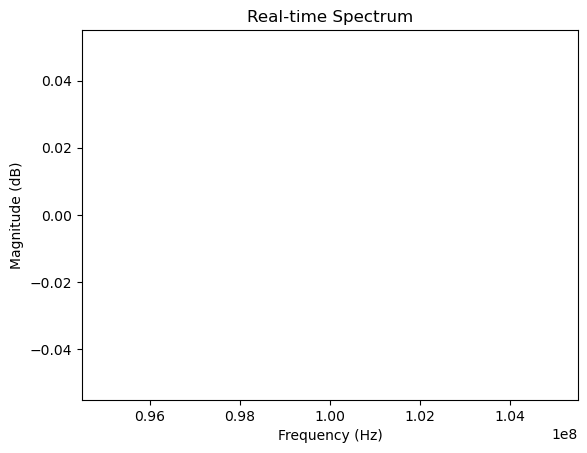

In [7]:
import adi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def plot_realtime_spectrum(pluto, center_freq, span, num_points):
    # 设置PlutoSDR参数
    pluto.rx_lo = int(center_freq)
    pluto.rx_rf_bandwidth = int(span)
    pluto.sample_rate = int(span) * 2  # 采样率为RF带宽的两倍

    # 创建图形
    fig, ax = plt.subplots()
    x = np.linspace(center_freq - span/2, center_freq + span/2, num_points)
    line, = ax.plot(x, np.zeros_like(x))

    # 更新函数
    def update(frame):
        data = pluto.rx()
        fft_data = np.fft.fft(data)
        fft_mag = np.abs(fft_data)
        fft_mag_db = 10 * np.log10(fft_mag)
        line.set_ydata(fft_mag_db)
        return line,

    # 开始动画
    ani = FuncAnimation(fig, update, frames=range(100), blit=True)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('Real-time Spectrum')
    plt.show()

# 创建PlutoSDR对象
pluto = adi.Pluto('ip:192.168.2.1')

# 指定频率范围和参数
center_freq = 100e6  # 中心频率 100 MHz
span = 10e6  # 频率范围 10 MHz
num_points = 1024  # FFT点数

# 实时显示频谱图
plot_realtime_spectrum(pluto, center_freq, span, num_points)


In [3]:
iio_info

NameError: name 'iio_info' is not defined

In [3]:
import adi
import numpy as np
sdr = adi.Pluto('ip:192.168.2.1')
sdr.tx_lo = 435000000  # 设置发送频率，2.4 GHz
sdr.tx_rf_bandwidth = 1000000  # 设置RF带宽
sdr.tx_hardwaregain_chan0 = 0  # 设置增益
sdr.tx_cyclic_buffer = True  # 循环发送
def generate_qpsk(num_samples):
    bits = np.random.randint(0, 2, num_samples * 2)  # 生成随机比特
    symbols = bits[0::2] + 1j * bits[1::2]  # 形成复数符号
    return symbols

# 配置QPSK信号
fs = int(2e6)  # 采样率
num_samples = 1024
qpsk_signal = generate_qpsk(num_samples)

# 确保信号符合Pluto的采样率
upsampled_signal = np.repeat(qpsk_signal, fs // num_samples)

# 发送信号
sdr.tx(upsampled_signal)

In [19]:
sdr=None

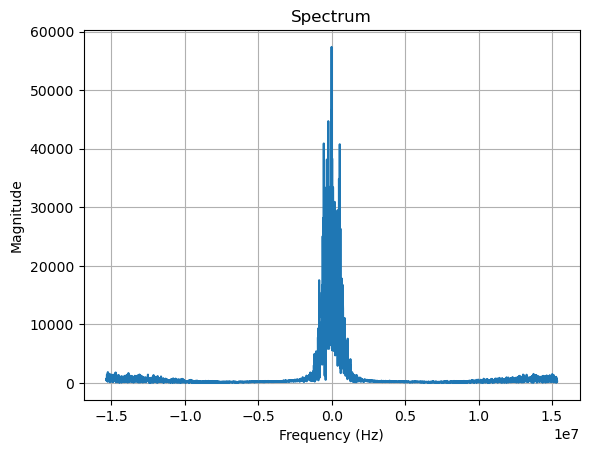

In [17]:
import adi
import numpy as np
import matplotlib.pyplot as plt

# 设置Pluto SDR设备
sdr = adi.Pluto('ip:192.168.2.1')
sdr.rx_lo = 435000000  # 设置接收频率（与发送频率匹配）
sdr.rx_rf_bandwidth = 1000000  # 设置RF带宽
sdr.rx_buffer_size = 4096  # 设置接收缓冲区大小

# 接收信号
samples = sdr.rx()

# 计算频谱
freqs = np.fft.fftfreq(len(samples), 1 / sdr.sample_rate)
spectrum = np.fft.fft(samples)

# 绘制频谱图
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(np.abs(spectrum)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Spectrum")
plt.grid(True)
plt.show()